Testing the graph chatbot

In [1]:
from utils.chatbot_graph import app

USER_AGENT environment variable not set, consider setting it to identify your requests.


ImportError: cannot import name 'thread' from 'utils.chatbot_graph' (c:\Users\pablo\Desktop\P - Proyectos en Curso\ai-curated-articles\agent\my-app\app\article-prep-agent\v2\implementations\local_audio_chat_demo\utils\chatbot_graph.py)

In [2]:
app.invoke({"question":"current relations between Venezuela and Spain"}, thread)["generation"]

"The relations between Venezuela and Spain are currently strained. Tensions have increased due to Venezuela's arrest of an Argentine officer, which has also affected Spain because of previous similar incidents involving Spanish citizens. This situation is further complicated by Spain's recognition of an opposition candidate in Venezuela, which the Venezuelan government sees as interference. Historically, their relationship has been complex, often influenced by differing political ideologies."

## Tweaking `chatbot_graph.py`

_______________________________

In [58]:
wa = StateGraph(GraphState)

# Add a node (action) to the graph
wa.add_node("search_web", search_web)

# Set the entry point for the graph (optional, but typically useful for defining the start)
wa.set_entry_point("search_web")

# Add an edge from the "search_web" node to the END node
wa.add_edge("search_web", END)

# Compile the graph
wa.compile()

In [85]:
from langgraph.constants import Send

In [86]:
import logging

In [3]:
# vectorstore.save_local("vectors")

In [1]:
from datetime import datetime

In [ ]:
import time

In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
import time
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langsmith import traceable
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from typing import List, Dict, Any
import os
from langchain_community.document_loaders import UnstructuredMarkdownLoader
import json
from langchain.schema import Document
from langgraph.graph import END, StateGraph
from tavily import TavilyClient, AsyncTavilyClient
# tavily_async_client = AsyncTavilyClient()
from datetime import datetime
from pydantic import BaseModel, Field
from typing import Union
from dataclasses import dataclass
from typing import Generator

tavily_client = TavilyClient()

@dataclass
class StreamResponse:
    content: str
    additional_kwargs: Dict[str, Any]
    response_metadata: Dict[str, Any]
    id: str


### State
class SearchQueriesParams(BaseModel):
    n_queries : int=Field(description="Number of queries to generate")
    
    queries: List[str] = Field(
        description="A list of strings representing the search queries to be executed.",
    )
    tavily_days: List[Union[int, None]] = Field(
        description="A list of integers representing the number of days to limit search results for each query (e.g., 7 for last week), or None for no time restriction. Each value corresponds to a query in the 'queries' list.",
    )
    tavily_topic: List[str] = Field(
        description="A list of strings indicating the type of search for each query: 'news' for time-sensitive queries or 'general' for unrestricted searches. Each value corresponds to a query in the 'queries' list.",
    )


#we'll reference to this object very often to add new docs...etc
    
class GraphState(TypedDict):
    news_summary : str 
    question : str
    question_type : Union[str, str]
    generation : str
    web_search : Union[str, str] 
    search_queries_params : SearchQueriesParams
    documents : str #the concatenated list of documents text content (or search results)
    decission : str
    feedback : Union[None, str]
    iterations:int
    streaming_avaiable:bool
    response_stream : Generator[StreamResponse, None, None]
    generation:str

class InputState(TypedDict):
    
    news_summary:str
    question:str


class OutputState(TypedDict):
    
    streaming_avaiable:bool
    response_stream : Union[Generator[StreamResponse, None, None], None]
    generation:Union[str, None]
    

# Check if the directory and files are readable
directory = './rag_docs'
# print(os.access(directory, os.R_OK))  # Checks if the directory is readable
os.chmod('./rag_docs', 0o755)


markdown_folder_path = "./rag_docs"  # Set the path to your folder
documents = []

# Iterate over all .md files in the directory
for file in os.listdir(markdown_folder_path):
    if file.endswith('.md'):
        markdown_path = os.path.join(markdown_folder_path, file)                     #=fast
        loader = UnstructuredMarkdownLoader(markdown_path, mode="single", strategy="precise")
        documents.extend(loader.load())  # Add loaded documents to the list

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200, chunk_overlap=100, add_start_index=True #starting char pos.
    #size of characters for each chunk
    #2nd param: will let us have a little portion of the prev. chunk
    # so in case the key info is in that chunk, we can have a way to get those prev chars if needed 
    
    #
)
all_splits = text_splitter.split_documents(documents)

#the so-called chroma database
local_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
persist_dir = "./chroma_db"
os.makedirs(persist_dir, exist_ok=True)

vectorstore = Chroma.from_documents(documents=all_splits, embedding=local_embeddings,
                                    persist_directory=persist_dir)


retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3},
                                    )


llm = ChatOpenAI(model="gpt-4o", temperature=0) 

llm_json = ChatOpenAI(
        model="gpt-4o",
        temperature = 0,
        model_kwargs={"response_format": {"type": "json_object"}})


#---------------------
#prompts

#TODO: we are trying to address the case where it gets an input question which is missleading
docs_answer_generation_instructions = """
You are an assistant for question-answering tasks inside a phone call conversation.

Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Keep the answer concise and optimized to reduce latency, in a spoken language style.

If provided, there will be a separate message with feedback about what to improve from the previous generation attempt. Use this feedback to enhance your response while maintaining grounding in the provided context.

Additionally, evaluate whether the provided context contradicts, corrects, or invalidates the user's question. If you are 100% certain that the question is misleading, incorrect, or based on faulty assumptions, use the context to explain why the question is problematic and provide the correct information. In such case, justify your answer with explicit references to the context. 

You must also keep in mind that you're answering questions related to either the news of the week, current issues, or historical questions, so always respond appropriately by connecting your answer to the spoken topics, which I'll attach below as a brief summary.

Question: {question}
Context: {context}

Remember: 
- Only correct or challenge the user's question when the context provides indisputable evidence to do so. Otherwise, answer normally.
- If feedback was provided, ensure your response addresses all the improvement points while staying faithful to the context.
"""

query_writer_instructions = """
Given the user's background and the question provided below, generate an appropriate number (n) of relevant queries to search on the internet in order to gather sufficient information to answer the question.
You can generate a maximum of 2 queries. Be sure you provide a precisse amount of queries to have a fast and accurate result, don't search more than needed.

If provided, there will be a separate message with feedback about why previous queries were not useful. Use this feedback to avoid similar issues and generate more effective queries.

**Current Date**: {current_date}

**Important Note**: A separate message includes a list of previously searched queries (`searched_queries`). Consider these queries and evaluate why they may not have been useful (e.g., irrelevant results, overly broad/narrow focus, or failure to address the question fully). Use this evaluation and any provided feedback to refine, reformulate, or supplement the queries to ensure better results. If no `searched_queries` are provided, proceed without them.

**Datetime Marker Awareness**:  
When generating queries, use datetime markers only if appropriate to the query context:

1. **Time-Sensitive or Current Events (`tavily_topic="news" and tavily_days=7`)**:  
   - **Do not include any explicit datetime markers** (e.g., "2025" or "January 2025") in the search query, as `tavily_days=7` already ensures the query focuses on recent results.  
   - If the user's question explicitly includes time hints (e.g., "yesterday," "last week"), calculate the corresponding date relative to **Current Date** (e.g., "yesterday" = `{current_date} - 1 day`) and use this date in the query.  
   - Otherwise, avoid adding datetime markers for time-sensitive queries, as they are unnecessary and may limit search results.  

2. **General or Historical Topics (`tavily_topic="general" and tavily_days=None`)**:  
   - Include datetime markers only when they clarify the query or provide precision (e.g., "economic crisis Spain 2008").  
   - Avoid unnecessary datetime markers for well-known historical events (e.g., "Battle of Lepanto"), as the event is self-contained in history.  

3. **Redundancy**: Ensure datetime markers are added only if needed for precision based on the query context and `tavily` parameters.  

Failure to follow these guidelines may result in ineffective or overly narrow queries.

### Query Complexity and Necessity:
- If the question is straightforward (e.g., "What is the capital of Spain?"), generate a single query.
- For more complex or multi-faceted questions, generate multiple queries to ensure all relevant aspects are covered without redundancy.
- If feedback was provided, adjust query specificity and coverage accordingly.

Renember to not use 2 queries unless you're completely sure it's needed such amount.

For each query, you must specify these parameters:
### Tavily-Specific Web Search Parameters:
For each query, set the Tavily parameters as follows:
- **tavily_topic**:  
   - Use `"news"` if the query is related to time-sensitive or current events.  
   - Use `"general"` for technical, historical, or non-time-sensitive topics.  
- **tavily_days**:  
   - Set `7` only if `tavily_topic="news"`.  
   - Set `None` if `tavily_topic="general"`.
---
**User question**: {question}
"""

docs_grader_instructions = """

    You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.

    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question}
"""


generation_grader_instructions = """

You are a grader assessing whether an answer is grounded in or supported by a set of facts. Additionally, evaluate whether the answer correctly identifies and explicitly addresses any misleading or incorrect assumptions in the user's question, based on the provided facts.

If the answer correctly identifies and addresses such misleading or incorrect assumptions, assign a `"yes"` to the `score` key, even if the user's question contains inaccuracies.

For example:
- Question: "Who was Fernando Hitler?"
  * Incorrect Assumption: The name "Fernando Hitler" is historically inaccurate.
  * Correct Response: Clarifies that no person named Fernando Hitler exists in historical records and offers accurate information about Adolf Hitler if relevant.
  * Outcome: Score "yes" because the response correctly addresses the misleading premise.

Your task:
1. Determine whether the answer is factually grounded and addresses misleading or incorrect assumptions.
2. If the answer successfully corrects such assumptions and provides a grounded response, score `"yes"`.
3. If the answer fails, provide feedback to improve it.

Provide your assessment as a JSON with:
- A 'score' key with value 'yes' or 'no'
- If the score is 'no', include a 'feedback' string key with specific guidance on:
  * Identifying and addressing misleading assumptions.
  * Correcting factual errors or omissions.
  * Enhancing clarity and conciseness.
  * Aligning with weekly news context if applicable.

Here are the facts:
\n ------- \n
{documents}
\n ------- \n

Here is the generated answer:
\n ------- \n
{generation}
\n ------- \n

Respond only with the JSON object, no explanation.

"""

answer_grader_instructions = """
You are a grader assessing whether an answer is useful and effectively resolves the user's question. Additionally, evaluate whether the answer appropriately challenges and corrects any misleading or incorrect assumptions in the question, if the context justifies such corrections.

If the answer correctly identifies and addresses such misleading assumptions, assign a `"yes"` to the `score` key, even if the user's question contains inaccuracies.

For example:
- Question: "Who was Fernando Hitler?"
  * Incorrect Assumption: The name "Fernando Hitler" is historically inaccurate.
  * Correct Response: Clarifies that no individual named Fernando Hitler exists in historical records, redirecting the user to relevant facts about Adolf Hitler if applicable.
  * Outcome: Score "yes" because the response correctly addresses the misleading premise.

Your task:
1. Evaluate whether the answer resolves the user's question and identifies misleading assumptions when applicable.
2. If the answer successfully corrects these issues and is useful, score `"yes"`.
3. If the answer fails, provide feedback on how it can improve.

### Specific Evaluation Criteria for Query Generation:
If the user's question pertains to **time-sensitive or current events**, and:
1. The generated queries incorrectly use explicit datetime markers (e.g., "January 2025") despite `tavily_days=7` and `tavily_topic="news"`, assign `"no"` to the `score` key.
2. If the user's question does not include any explicit temporal hints (e.g., "yesterday"), and the queries still include unnecessary datetime markers, this is a misuse and warrants `"no"`.
3. If the answer does not appropriately tailor queries to the user's question (e.g., redundant or overly broad), assign `"no"`.

When assigning a `"no"` score, provide detailed and actionable feedback under the `feedback` key to ensure the query generation improves. Your feedback should:
- Highlight the improper use of datetime markers if applicable.
- Suggest excluding datetime markers when `tavily_days=7` and the question lacks explicit temporal hints.
- Emphasize aligning query parameters (e.g., `tavily_topic` and `tavily_days`) with the user's question context.
- Recommend clearer or more precise query formulations to address the user's needs.

### Additional Context:
- **Already Searched Queries**: You will receive the list of already searched queries as a separate message below. Use this information to evaluate whether the generated queries address gaps, improve upon previous attempts, and avoid redundant or ineffective formulations.

Provide your assessment as a JSON with:
- A `score` key with value `"yes"` or `"no"`.
- If the score is `"no"`, include a `feedback` key focusing on:
  * Addressing improper datetime marker usage.
  * Improving query clarity and relevance.
  * Adhering to `tavily` parameter requirements.
  * Filling gaps in information and tailoring to the user’s question.

Here is the generated answer:
\n ------- \n
{generation}
\n ------- \n

Here is the original user question:
\n ------- \n
{question}
\n ------- \n

Here are the already searched queries:
\n ------- \n
{searched_queries}
\n ------- \n

Respond only with the JSON object, no explanation.

# """

@traceable
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    # print("---RETRIEVE---")
    i = time.time()
    
    question = state["question"]

    # Retrieval
    retrieved_docs = retriever.invoke(question)
    
    context = ' '.join([doc.page_content for doc in retrieved_docs])
    
    e = time.time()
    
    print("retrieve(): ", e-i, " secs")
    
    return {"documents": context, "question": question}
#

@traceable
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    # print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    context = state["documents"]
    
    
    i = time.time()

    system_instructions = docs_grader_instructions.format(question=question, document=context)
    messages = [
        {"role": "system", "content": system_instructions},
        # {"role": "user", "content": f": {}"}
    ]   
    
    
    model = ChatOpenAI(
            model="gpt-3.5-turbo-0125",
            temperature = 0,
            model_kwargs={"response_format": {"type": "json_object"}})

    
    #llm_json
    grade = json.loads(model.invoke(messages).content)["score"]
    # print(grade)
    
    e = time.time()

    print("grade_documents(): ", e-i, " seconds")
    
    if grade.lower() == "yes":
        # print("---GRADE: DOCUMENT RELEVANT---")
        return {"documents": context, "question": question, "web_search": "No"}
    else:
        # print("---GRADE: RETRIEVED DOCUMENTS NOT RELEVANT, RUNNING WEB SEARCH INSTEAD---")
        return {"documents": context, "question": question, "web_search": "Yes"}


@traceable
def handle_trivial_question(state:InputState):
    """
    Determines whether the question is trivial or irrelevant to run RAG or websearch.
    Uses an LLM to classify the question as "is_trivial" or "not_trivial".

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): Updated state with the classification ("is_trivial" or "not_trivial").
    """
    
    question = state["question"]
    
    # LLM prompt to classify the question as trivial or not
    trivial_classification_instructions = """
    You are an AI chatbot. Classify the user's question as either "is_trivial" or "not_trivial". 
    The question is considered "trivial" if it is a greeting, a simple personal question (e.g., "What's your name?"), 
    , incomplete or missleading questions, or if it doesn't require to search for detailed information to answer.
    If the question is a valid request for information or involves specific queries that require processing or websearch, 
    classify it as "not_trivial".
    
    Example trivial questions: 
    - "Hello"
    - "What's your name?"
    - "How are you?"
    
    Example non-trivial questions:
    - "Tell me the latest news on AI"
    - "What is the capital of France?"
    - "How does a neural network work?"
    
    Question: {question}
    Please respond with either "is_trivial" or "not_trivial", no preambles or explanations
    """

    i = time.time()

    # Create the system message with the classification instructions and the question
    system_instructions = trivial_classification_instructions.format(question=question)
    
    messages = [
        {"role": "system", "content": system_instructions},
        {"role": "user", "content": f"Question: {question}"}
    ]    

    model = ChatOpenAI(
            model="gpt-3.5-turbo-0125",
            temperature = 0)
            # model_kwargs={"response_format": {"type": "json_object"}})

    # Get the classification from the LLM
    decission = model.invoke(messages).content.lower()
    #llm
    
    e = time.time()

    print("handle_trivial_question(): ", e-i, " seconds")
    
    if decission == "is_trivial":
        return {"question": question, "question_type": "is_trivial", "iterations":0}
    
    elif decission == "not_trivial":
        return {"question": question, "question_type": "not_trivial", "iterations":0}
    
    
@traceable
def answer_trivial_question(state):
    """
    Handle trivial or irrelevant questions by using an LLM to generate a response.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updated state with a response to the trivial question.
    """
    question = state["question"]

    # Trivial question generation instructions
    # trivial_answer_generation_instructions = """
    # You are an AI chatbot. 
    # """

    # # Send the question and instructions to the LLM to generate a response
    # system_instructions = trivial_answer_generation_instructions + f"User's question: {question}"

    # messages = [
    #     {"role": "system", "content": system_instructions},
    #     {"role": "user", "content": f"Question: {question}"}
    # ]    
    
    messages = [
        {"role": "system", "content": "You are an AI chatbot answering a user's question."},
        {"role": "user", "content": f"Question: {question}"}
    ]    

    # Call the LLM to generate the response
    # response = llm.with_config().invoke(messages)
    
    # response = llm.invoke(messages)
    
    i = time.time()
    
    model = ChatOpenAI(
            model="gpt-3.5-turbo",
            temperature = 0,
            max_completion_tokens=50)
            # model_kwargs={"response_format": {"type": "json_object"}})

    response_stream = model.stream(messages, max_completion_tokens=500,
                                 temperature=0)
    #llm
    e = time.time()

    print("answer_trivial_question(): ", e-i, " seconds")
    
    # response.id = "final_pred"
    # Return the state with the generated response for trivial question
    return {"question": question, "streaming_avaiable": True, "response_stream":response_stream, "generation":None}
#                                               #we put the generation key (final answer) in the state
    

@traceable
def answer_with_docs(state):
    """
    Generate answer either using RAG on retrieved documents or web search results

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    # print("---GENERATE---")
    question = state["question"]
    context = state["documents"]
    
    feedback = state.get("feedback", None)
    
    i = time.time()

    system_instructions = docs_answer_generation_instructions.format(question=question, context=context)
    
    messages = [
        {"role": "system", "content": system_instructions},
        #todo: check if this additional param is necessary
        {"role": "user", "content": f": Here is the news summary shown to the user before: {state['news_summary']}"},
        {"role":"user", "content":f"Here is some feedback (if applicable): {feedback}"}
    ]   
                            #gpt3.5-turbo
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

    
    #llm
    answer = model.invoke(messages, max_tokens=150, temperature=0.1) #.response lo quitamos
    
    e = time.time()

    print("answer_with_docs(): ", e-i, " seconds")
    
    return {"documents": context, "question": question, "generation": answer,
            "streaming_avaible":False}
    #for now, streaming won't be avaiable in this node given that the generation is reviewed afterwards
    #that means that we need to have the entire generation for that, so we can't directly stream the output
    #and also, because it can get a 2nd revision (max_iterations=2)
#

@traceable
def generate_queries(state):
    """ Generate search queries for a report section, and set tavily_topic and tavily_days"""

    i = time.time()
    
    feedback = state.get("feedback", None)
    
    # Generate queries and tavily params with the custom pydantic model

                        #gpt4o-mini , gpt4-turbo
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

    structured_llm = model.with_structured_output(SearchQueriesParams)
                    #llm.
                    
    #already searched queries    
    searched_queries = state.get("search_queries_params", None) #looking for already searched queries
    
    
    current_datetime = datetime.now()

# Format it as a string (optional, e.g., 'YYYY-MM-DD HH:MM:SS')
    current_datetime_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    # Format system instructions                   #instead of number_of_queries=3, now it also decides such number
    system_instructions = query_writer_instructions.format(question=state["question"],
                                                           current_date=current_datetime_str,
                                                        )

    print(f"already searched queries (if applicable): {searched_queries}")
    
    messages = [{"role": "system", "content": system_instructions},
                {"role":"user", "content":f"feedback (if applicable): {feedback}"}]
    
    if searched_queries is not None:
        messages.append({"role": "user", "content": f"already searched queries (if applicable): {searched_queries}"})


    search_params = structured_llm.invoke(messages)
    
    n_queries = search_params.n_queries
    queries = search_params.queries  # Assuming 'queries' is the result you expect from the LLM response
    tavily_topic = search_params.tavily_topic  # LLM response for tavily_topic
    tavily_days = search_params.tavily_days
    
    search_queries_params = SearchQueriesParams(
        n_queries=n_queries,
        queries=queries,
        tavily_topic=tavily_topic,
        tavily_days=tavily_days
    )
    
    e = time.time()
    print("Elapsed time generate_queries(): ", e-i, " seconds")
    return {"search_queries_params": search_queries_params}


#TODO: we need to make all the graph either async or sync, not mixed , see https://github.com/langchain-ai/langgraph/issues/2928#issuecomment-2569915286

#TODO NOTE: we have selected to get n=3 results per query call (maybe we should try setting it to 1 to reduce latency)
#or keeping such amount to ensure it retrieves trustworthy sources

def tavily_search_sync(search_queries:List[str], tavily_topics:List[str], tavily_days=List[Union[str, None]]):
    """
    """
    search_docs = []

    
    for ix, query in enumerate(search_queries):
        
        # print(query)
        if tavily_topics[ix] == "news":
            
            # print("gonna search ", tavily_topics[ix])
            result = tavily_client.search(  
                query,
                days=tavily_days[ix], #always 7 (for now)
                topic="news", 
                max_results=1 #todo: ---> DECIDE THE NUMBER OF RESULTS
                # include_raw_content=True,
               
            )
        else:
            result = tavily_client.search(  
                query,
                topic="general", 
                max_results=1 #todo: ---> DECIDE THE NUMBER OF RESULTS
                # include_raw_content=True,
               
            )
            
        search_docs.append(result)

    return search_docs

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        # sources_list = search_response['results']
        sources_list = search_response.get('results', [])
        
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                # sources_list.extend(response['results'])
                sources_list.extend(response.get('results', []))
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        url = source.get('url')
        # if source['url'] not in unique_sources:
        #     unique_sources[source['url']] = source
        if url and url not in unique_sources:
            unique_sources[url] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()


def search_web(state):
    """ Web search based based on the question."""
    
    # Get search_queries_params from state (which includes lists of queries, tavily_topic, and tavily_days)
     
    search_queries_params = state["search_queries_params"]
    n_queries = search_queries_params.n_queries  # Number of queries to generate
    queries = search_queries_params.queries  # List of queries
    tavily_topics = search_queries_params.tavily_topic  # List of topics ('news' or 'general')
    tavily_days = search_queries_params.tavily_days  # List of days for limiting search (or None)

    print(f"gonna generate {n_queries} queries")
    # Check if lengths of queries, tavily_topics, and tavily_days are equal
    if not (n_queries == len(queries) == len(tavily_topics) == len(tavily_days)):
        raise ValueError("The lengths of queries, tavily_topics, and tavily_days must be equal.")
    
    # Web search using async function with corresponding parameters
    # for query, topic, days in zip(queries, tavily_topics, tavily_days):
    #     search_doc = tavily_search_sync([query], topic, days)  # Replace with synchronous function
    #     search_docs.extend(search_doc)  # Add results to the overall list

    start_time = time.time()
    
    response = tavily_search_sync(search_queries=queries, tavily_topics=tavily_topics, tavily_days=tavily_days)
    
    
    # Deduplicate and format sources                                             #1000 -- check annotations whasap
    source_str = deduplicate_and_format_sources(response, max_tokens_per_source=5000, include_raw_content=True)

    web_results = Document(page_content=source_str,
                           
                        metadata={"source": "Tavily Web Search"} )
    
    end_time = time.time()
    
    print("[*] Elapsed time for search: ", (end_time-start_time))
    #we'll also add to the vectorstore the websearch results so next time it won't need to run web search again for specific questions
    vectorstore.add_documents([web_results])
    
    return {"documents": web_results.page_content}

@traceable
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generated response is grounded in the document and answers the question.
    
    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    # print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    context = state["documents"] #it can be either the retrieved docs or the web search results
    generation = state["generation"]
    
    i = time.time()

    
    n_iterations = state.get("iterations",None)
    
    if n_iterations!=None:
        n_iterations+=1
    else:
        n_iterations=1
        
        # force_stop = state.get("force_stop",None)
    if n_iterations==2:
        return {"decission":"force_stop", "feedback":None,
                "generation":state["generation"]}
        
        
    generation_grader_prompt = generation_grader_instructions.format(documents=context, generation=generation)
    
    already_searched_queries = state.get("search_queries_params", None)                                                               
   
    answer_grader_prompt = answer_grader_instructions.format(generation=generation, question=question,
                                                             searched_queries=f"already searched queries: if applicable: {already_searched_queries}")
    
    
    messages = [
        {"role": "system", "content": generation_grader_prompt},
        # {"role": "user", "content": f": {}"}
    ]   
    
    
    
    # llm = ChatOpenAI(model="gpt-4o", temperature=0) 

    model = ChatOpenAI(
            model="gpt-3.5-turbo",
            temperature = 0,
            model_kwargs={"response_format": {"type": "json_object"}})


    #todo: instead of using llm_json
    response = json.loads(model.invoke(messages).content)
    #note: faster model
    
        
    # print(grade)
    # print("Generation grader output json:", response)
  
  #----------------  
    if response["score"].lower() == "yes": #the answer is grounded in the documents
        
    
        #now, we check such generation correctly answers the question
        messages = [
            {"role": "system", "content": answer_grader_prompt},
            # {"role": "user", "content": f": {}"}
        ]   
        
        model = ChatOpenAI(
            model="gpt-3.5-turbo",
            temperature = 0,
            model_kwargs={"response_format": {"type": "json_object"}})
 
        
        #note: llm_json.invoke()
        response = json.loads(model.invoke(messages).content)
        # print("answer grader output json:", response)
        # print(type(response))
        
        
        if response["score"].lower() == "yes":
            
            e = time.time()
            
            print("grade_documents_v_questiom(): ", e-i, " seconds")
            # print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS, AND IT ANSWERS THE QUESTION---")
            # return "useful"
            return {"decission":"useful", "feedback":None, "iterations":n_iterations, #si es useful, acaba
                    "generation":generation, "streaming_avaiable":False, "response_stream":None}
            
            
                                #para que una respuesta sea buena
                                #debera acabar siendo = None
                                #por lo que un nodo no tomara feedback que no le corresponde
        
        
        else:
            e = time.time()
            
            print("grade_documents_v_questiom(): ", e-i, " seconds")
            # print("---DECISION: GENERATION DOES NOT ANSWER THE QUESTION, RUNNING WEBSEARCH---")
            # return "not_useful" #then we simply retry the websearch (only)
            return {"decission":"not_useful", "feedback":response["feedback"],
                    "iterations":n_iterations, "generation":generation, "streaming_avaiable":False, "response_stream":None}
            
    else:
        #IF THE MODEL HALLUCINATES, WE RE-RUN ONLY THE GENERATION
        
        # print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        # return "not_grounded"
        
        e = time.time()
            
        print("grade_documents_v_questiom(): ", e-i, " seconds")
    

        return {"decission":"not_grounded", "feedback":response["feedback"],
                "iterations":n_iterations, "generation":generation, "streaming_avaiable":False}
    
    
def process_final_pred(state):
    
    n_iterations = state["iterations"] #we don't want to surpass the iterations limit
    decission = state["decission"]
    
    if decission == "useful" or n_iterations==2:
        last_pred = state["generation"]
        
        last_pred.id = "last_pred"
        
        state["generation"] = last_pred #ensure last pred have this unique id
#-------------------- graph
    
workflow = StateGraph(GraphState, input=InputState, output=OutputState)
# Define the nodes
workflow.add_node("handle_trivial_question", handle_trivial_question)
workflow.add_node("answer_trivial_question", answer_trivial_question) 
workflow.add_node("retrieve", retrieve) 
workflow.add_node("generate_queries", generate_queries)
workflow.add_node("websearch", search_web)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("answer_with_docs", answer_with_docs)
workflow.add_node("grade_generation_v_documents_and_question", grade_generation_v_documents_and_question)
workflow.add_node("detect_if_final_pred", process_final_pred)


#conditional nodes
def detect_trivial_question(state):
    """
    Determines whether the question is trivial or not

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    question_type = state["question_type"]
    # if question_type == "is_trivial":
    #     return "answer_trivial_question"
    # else:
    #     return "retrieve"
    return question_type


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    # print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        return "use_websearch"
    else:
        return "answer_with_docs"
    

workflow.set_entry_point("handle_trivial_question")

workflow.add_conditional_edges("handle_trivial_question",
                               detect_trivial_question,
                               {"is_trivial": "answer_trivial_question", "not_trivial": "retrieve"})

workflow.add_edge("answer_trivial_question", END)


workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate, #after running grade_documents, we get the key of websearch to know if we run it or not
    {
        "use_websearch": "generate_queries", #before websearch, we generate the queries through the generate_queries node
        "answer_with_docs": "answer_with_docs",
    },
)


workflow.add_edge("generate_queries", "websearch") 
workflow.add_edge("websearch", "answer_with_docs") #after web search, we go directly to generation
# workflow.add_edge("answer_with_docs", "handle_trivial_question")
workflow.add_edge("answer_with_docs", "grade_generation_v_documents_and_question")
workflow.add_edge("grade_generation_v_documents_and_question","detect_if_final_pred")


# workflow.add_conditional_edges( #conditional edges
#     "answer_with_docs",
#     grade_generation_v_documents_and_question,
#     {
#         "not_grounded": "answer_with_docs", #if the llm generation grader result is = "not supported", then re-try
#         "useful": END, #if it is useful, then end the process
#         "not_useful": "generate_queries", #if not useful, then re-create queries again given the previous one (if applicable) and run websearch
#     },
# )


def check_generation(state):
    
    
    if state["decission"] == "useful":
        
        # state["streaming_avaiable"] = False
        
        return "useful"
    
    elif state["decission"] == "not_useful":
        
        # state["streaming_avaiable"] = False

        
        return "not_useful"
    
    
    
    elif state["decission"] == "not_grounded":
        
        #doesnt work
        # state["streaming_avaiable"] = False

        
        return "not_grounded"
    
    elif state["decission"] == "force_stop":
        
        print("forcing stop of the graph...")
        # state["streaming_avaiable"] = False
        
        
        return "force_stop"
    
    
    print("current feedback provided ", state["feedback"])
        
    
workflow.add_conditional_edges( #conditional edges
    "grade_generation_v_documents_and_question",
    check_generation,
    {
        "not_grounded": "answer_with_docs", #if the llm generation grader result is = "not supported", then re-try
        "useful": END, #if it is useful, then end the process
        "not_useful": "generate_queries", #if not useful, then re-create queries again given the previous one (if applicable) and run websearch,
        "force_stop":END
    },
)


In [21]:

#--------------- compiling the graph

#todo: check if short term and long term memmory are useful
#todo: redefine the node of web search to generate multiple queries given the question (add tavily_days and tavily_topic too)
from langgraph.checkpoint.sqlite import SqliteSaver
from contextlib import ExitStack

stack = ExitStack()
memory = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))

app = workflow.compile() #checkpointer=memory

thread = {"configurable": {"thread_id":"1"}} #"recursion_limit":60

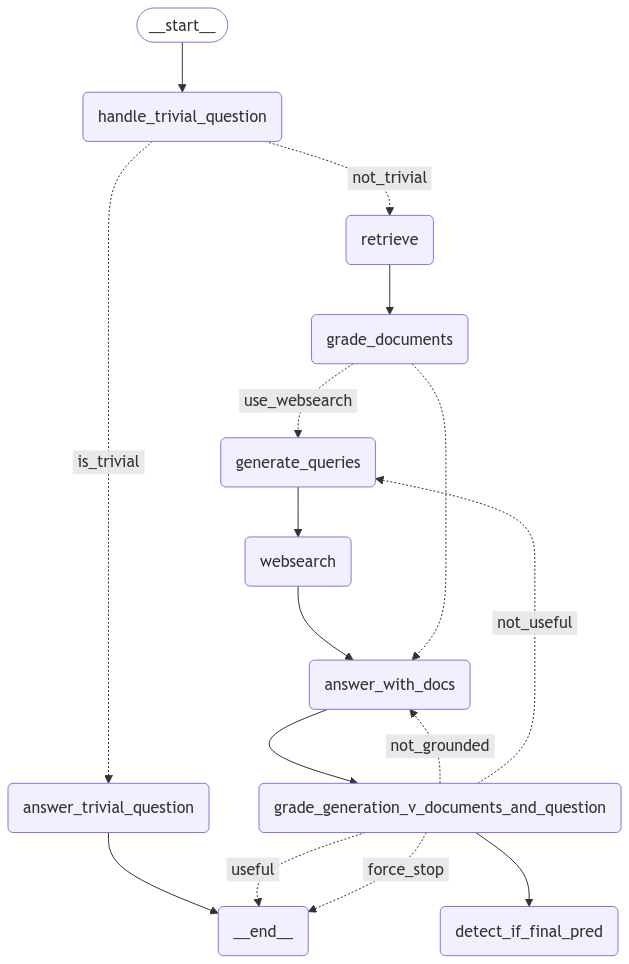

In [22]:
from IPython.display import Image

display(Image(app.get_graph(xray=1).draw_mermaid_png(
)))

In [162]:
# for i in model.stream(input="aaa", max_completion_tokens=500,
#                                        temperature=0):
    
#     print(i)

In [4]:
a = app.invoke(input={"question":"how are you", "news_summary":"example"})

handle_trivial_question():  0.9582333564758301  seconds
answer_trivial_question():  0.5984888076782227  seconds


In [140]:
a

{'streaming_avaiable': True,
 'response_stream': <generator object BaseChatModel.stream at 0x0000021186F52150>}

In [6]:
from utils.sst import transcribe_audio

In [7]:
text = transcribe_audio("narrative.wav")

In [8]:
text

"Ready to know what happened this week? Let's dive in. First up, fitness enthusiasts are buzzing about high-intensity interval training, which promises to keep you burning calories long after your workout ends. Meanwhile, in the world of international affairs, Ukraine made headlines by using a naval drone to take down a Russian helicopter, marking a significant moment in their ongoing conflict. As Asia celebrated the arrival of 2025 with spectacular fireworks, Elon Musk stirred controversy in Germany by endorsing a far-right party, leading to a media shake-up. Across the Atlantic, Donald Trump surprised many by supporting Elon Musk and the H-1B visa program, causing ripples within the Republican Party. In entertainment, Lily-Rose Depp is making waves with her role in the new Nasratu film, while Trump mourns the loss of former U.S. President Jimmy Carter, who passed away at 100, leaving behind a legacy of peace and humanitarian work. Spain is facing unrest as public employees deal with 

In [23]:
a = app.invoke(input={"question":"que ocurrio en el atentado de nueva orleans", "news_summary":text})

handle_trivial_question():  1.0071086883544922  seconds
retrieve():  0.5809445381164551  secs
grade_documents():  1.272484302520752  seconds
answer_with_docs():  2.523061990737915  seconds
grade_documents_v_questiom():  2.3770363330841064  seconds


In [24]:
a

{'streaming_avaiable': False,
 'response_stream': None,
 'generation': AIMessage(content='El atentado en Nueva Orleans ocurrió el 1 de enero de 2025, cuando un conductor embistió a una multitud en Bourbon Street, matando al menos a 15 personas e hiriendo a muchas más. La víctima más destacada fue Tiger Bech, un exjugador de fútbol de Princeton, quien sufrió lesiones internas fatales. Las autoridades están investigando el incidente, que el alcalde de Nueva Orleans ha calificado como un "ataque terrorista".', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 5035, 'total_tokens': 5133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 4864}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred

In [97]:
a["generation"].content

'Donald Trump is the 45th President of the United States, having served from January 2017 to January 2021. He was born on June 14, 1946, in Queens, New York, and took over his father\'s real estate business, renaming it the Trump Organization. Before his presidency, he was known for his reality TV show "The Apprentice" and his book "The Art of the Deal." Trump is notable for his unconventional communication style, particularly through social media. He was impeached twice during his presidency and lost reelection to Joe Biden in 2020.'

In [25]:
inputs = {"question": "what did elon musk say about UK right wing party?", "news_summary":text}
app.invoke(inputs)

handle_trivial_question():  0.9483010768890381  seconds
retrieve():  1.9162795543670654  secs
grade_documents():  1.029559850692749  seconds
answer_with_docs():  2.3317995071411133  seconds
grade_documents_v_questiom():  2.110718011856079  seconds


{'streaming_avaiable': False,
 'response_stream': None,
 'generation': AIMessage(content='Elon Musk recently called for the UK’s right-wing Reform Party to replace its leader, Nigel Farage, stating that Farage "doesn\'t have what it takes." This came after Musk criticized the UK’s left-leaning Prime Minister, Keir Starmer.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 2749, 'total_tokens': 2803, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1664}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred', usage_metadata={'input_tokens': 2749, 'output_tokens': 54, 'total_tokens': 2803, 'input_token_details': {'audio': 0, 'cache_read': 1664}, 'output_token_details': {'audio': 0, 'reasoni

In [26]:
a.keys()


dict_keys(['streaming_avaiable', 'response_stream', 'generation'])

_________

In [39]:
class OverallState(TypedDict):
    #includes all the keys of both input and output, + any other intermediate
    a:int
    b:int
    c:int
    ou_mami:str
    

class GGInput(TypedDict):
    a : int
    b : int
    
class GGOutput(TypedDict):
    c:int
    # b : int

In [42]:
wowo = StateGraph(OverallState, input=GGInput, output=GGOutput)
# Define the nodes

def multiply_node(state): #since its the entrypoint node, it should be state:GGInput
    
    a = state["a"]
    b = state["b"]
    
    return {"c":a*b}
wowo.add_node("multiply_a_with_b", multiply_node)
# workflow.add_node("answer_trivial_question", answer_trivial_question) 
# workflow.add_node("retrieve", retrieve) 

wowo.set_entry_point('multiply_a_with_b')
wowo.add_edge('multiply_a_with_b', END)

riri = wowo.compile()
# workflow.add_node("generate_queries", generate_queries

In [43]:
riri.invoke({"a":5, "b":2})

{'c': 10}

_____________

____________________

In [4]:
model = ChatOpenAI(model="gpt-4o-mini")

In [18]:
chunks = []
for chunk in model.stream("what color is the sky?", max_completion_tokens=500,
                          temperature=0):
    chunks.append(chunk)
    print(chunk.content, end="|", flush=True)

|The| color| of| the| sky| can| vary| depending| on| several| factors|,| including| the| time| of| day|,| weather| conditions|,| and| atmospheric| particles|.| During| a| clear| day|,| the| sky| typically| appears| blue| due| to| the| scattering| of| sunlight| by| the| Earth's| atmosphere|.| This| phenomenon| is| known| as| Ray|leigh| scattering|.| At| sunrise| and| sunset|,| the| sky| can| display| a| range| of| colors|,| including| orange|,| pink|,| and| red|,| due| to| the| angle| of| the| sun| and| the| increased| distance| the| light| travels| through| the| atmosphere|.| On| cloudy| or| over|cast| days|,| the| sky| may| appear| gray|.| Additionally|,| pollution|,| dust|,| and| other| particles| can| also| affect| the| sky|'s| color|.||

In [22]:
chunks[2]

AIMessageChunk(content=' color', additional_kwargs={}, response_metadata={}, id='run-03dbc03f-03db-441e-9ad3-6e68c5e86f8b')

In [27]:
from tts_variants import streamed_tts_langchain

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


ImportError: cannot import name 'streamed_tts_langchain' from 'tts_variants' (c:\Users\pablo\Desktop\P - Proyectos en Curso\ai-curated-articles\agent\my-app\app\article-prep-agent\v2\implementations\local_audio_chat_demo\tts_variants.py)

In [158]:
streamed_tts_langchain(model,
                       text="tell me a curiosity about americans")

Queued sentence: One interesting curiosity about Americans is their love for fast food.
Queued sentence: The United States is home to some of the largest and most recognizable fast-food chains in the world, such as McDonald's, Burger King, and Taco Bell.
Queued sentence: The fast-food industry has become a significant part of American culture, with many people enjoying the convenience and affordability it offers.
Queued sentence: In fact, it's estimated that Americans consume around 50 billion burgers each year!
Queued sentence: This phenomenon reflects not only dietary habits but also broader trends in lifestyle and consumer culture in the U.
Queued sentence: S.
Time taken to start playing audio clip: 2.6088027954101562 seconds
Time taken to start playing audio clip: 6.806114673614502 seconds
Time taken to start playing audio clip: 15.923211574554443 seconds
Time taken to start playing audio clip: 24.633734464645386 seconds
Time taken to start playing audio clip: 30.25316071510315 sec

_______________

______________________

In [104]:
from utils.sst import transcribe_audio

In [105]:
text = transcribe_audio("narrative.wav")

In [111]:
inputs = {"question": "que ocurrio en el atentado de nueva orleans?", "news_summary":text}

In [112]:
app.invoke(input=inputs)

handle_trivial_question():  1.2733216285705566  seconds
retrieve():  0.9772970676422119  secs
grade_documents():  1.1743078231811523  seconds
already searched queries (if applicable): None
Elapsed time generate_queries():  2.506319046020508  seconds
gonna generate 1 queries
[*] Elapsed time for search:  3.6064083576202393
answer_with_docs():  2.552968978881836  seconds
grade_documents_v_questiom():  2.28853702545166  seconds


{'generation': AIMessage(content='En el atentado de Nueva Orleans, que ocurrió el Día de Año Nuevo, 14 víctimas perdieron la vida. El FBI ha proporcionado una actualización detallada sobre los eventos relacionados con este ataque en Bourbon Street.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 896, 'total_tokens': 940, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred', usage_metadata={'input_tokens': 896, 'output_tokens': 44, 'total_tokens': 940, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [150]:
# from pprint import pprint
# for output in app.stream(inputs, thread):
#     for key, value in output.items():
#         pprint(f"Finished running: {key}:")

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'Finished running: detect_if_final_pred:'


In [86]:
from pprint import pprint
inputs = {"question": "what did elon musk say about UK right wing party?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value)

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'Finished running: detect_if_final_pred:'
None


In [87]:
app.invoke(inputs)

{'generation': AIMessage(content='Elon Musk recently called for the UK’s right-wing Reform Party to replace its leader, Nigel Farage, stating that "Farage doesn’t have what it takes." This came after Musk criticized the UK’s left-leaning Prime Minister, Keir Starmer.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 6014, 'total_tokens': 6069, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 5888}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred', usage_metadata={'input_tokens': 6014, 'output_tokens': 55, 'total_tokens': 6069, 'input_token_details': {'audio': 0, 'cache_read': 5888}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [14]:
inputs = {"question": "who has accused to who between Venezuela and Argentina?", "news_summary":text}


In [15]:
app.invoke(inputs)

handle_trivial_question():  1.068077802658081  seconds
retrieve():  0.558140754699707  secs
grade_documents():  0.9966485500335693  seconds
answer_with_docs():  1.5584099292755127  seconds
grade_documents_v_questiom():  2.177999973297119  seconds


{'generation': AIMessage(content='Venezuela has accused an Argentine officer of terrorism, which has contributed to the deteriorating relations between the two countries.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1618, 'total_tokens': 1643, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred', usage_metadata={'input_tokens': 1618, 'output_tokens': 25, 'total_tokens': 1643, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [16]:
inputs = {"question": "which is the current political party at germanu?", "news_summary":text}


In [17]:
app.invoke(inputs)

handle_trivial_question():  0.9733643531799316  seconds
retrieve():  0.6992456912994385  secs
grade_documents():  0.9832816123962402  seconds
already searched queries (if applicable): None
Elapsed time generate_queries():  1.618110179901123  seconds
gonna generate 1 queries
[*] Elapsed time for search:  2.277712345123291
answer_with_docs():  1.450340986251831  seconds
grade_documents_v_questiom():  2.016035795211792  seconds


{'generation': AIMessage(content='The current political party in Germany is the SPD, led by Chancellor Olaf Scholz, who is running for re-election in the upcoming 2025 federal election.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 907, 'total_tokens': 940, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred', usage_metadata={'input_tokens': 907, 'output_tokens': 33, 'total_tokens': 940, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [18]:
inputs = {"question": "when did elon musk come to the U.S?", "news_summary":text}


In [19]:
app.invoke(inputs)

handle_trivial_question():  0.9079451560974121  seconds
retrieve():  1.0117716789245605  secs
grade_documents():  1.0382065773010254  seconds
already searched queries (if applicable): None
Elapsed time generate_queries():  1.7156682014465332  seconds
gonna generate 2 queries
[*] Elapsed time for search:  4.6060967445373535
answer_with_docs():  1.2704432010650635  seconds
grade_documents_v_questiom():  2.0480756759643555  seconds


{'generation': AIMessage(content='Elon Musk moved to the U.S. in 1992.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 1140, 'total_tokens': 1155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred', usage_metadata={'input_tokens': 1140, 'output_tokens': 15, 'total_tokens': 1155, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


Sample event 

```python

{'event': 'on_chain_end',

 'data': {'output': 
 
  {'news_summary': "Ready to know ,
   'question': 'who is the nephew of Francisco Hitler?',
   'question_type': 'is_trivial',
   'generation': "There is no widely recognized historical figure named Francisco Hitler, and Adolf Hitler, the infamous leader of Nazi Germany, did not have a nephew by that name. Adolf Hitler did have a nephew named William Patrick Hitler, who was the son of Adolf's half-brother, Alois Hitler Jr. If you meant a different person or context, please provide more details.",
   'iterations': 0}},

 'run_id': 'b2236655-5928-4feb-8926-a65ea904b123',
 'name': 'LangGraph',
 'tags': [],
 'metadata': {},
 'parent_ids': []}

```

In [ ]:
{'event': 'on_chat_model_stream',
 'data': {'chunk':
     AIMessageChunk(content=' widely', 
                    additional_kwargs={}, response_metadata={},
                    id='run-bde93253-82d3-42a1-8584-88f0abd5ee8a')},
 
 'run_id': 'bde93253-82d3-42a1-8584-88f0abd5ee8a', 'name': 'ChatOpenAI',
 'tags': ['seq:step:1'], 'metadata': {'langgraph_step': 2, 
                                      'langgraph_node': 'answer_trivial_question', 'langgraph_triggers': ['branch:handle_trivial_question:detect_trivial_question:answer_trivial_question'], 'langgraph_path': ('__pregel_pull', 'answer_trivial_question'), 'langgraph_checkpoint_ns': 'answer_trivial_question:56ca808a-954c-1893-fb4d-3b16d1da3ac2', 'checkpoint_ns': 'answer_trivial_question:56ca808a-954c-1893-fb4d-3b16d1da3ac2', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0, 'ls_method': 'traceable'}, 'parent_ids': ['464e03d0-68ee-45ba-b9db-c65c36fadd5a']}


In [37]:
from langchain_core.messages import HumanMessage


In [44]:
event

{'event': 'on_chain_end',
 'data': {'output': {'news_summary': "Ready to know what happened this week? Let's dive in. First up, fitness enthusiasts are buzzing about high-intensity interval training, which promises to keep you burning calories long after your workout ends. Meanwhile, in the world of international affairs, Ukraine made headlines by using a naval drone to take down a Russian helicopter, marking a significant moment in their ongoing conflict. As Asia celebrated the arrival of 2025 with spectacular fireworks, Elon Musk stirred controversy in Germany by endorsing a far-right party, leading to a media shake-up. Across the Atlantic, Donald Trump surprised many by supporting Elon Musk and the H-1B visa program, causing ripples within the Republican Party. In entertainment, Lily-Rose Depp is making waves with her role in the new Nasratu film, while Trump mourns the loss of former U.S. President Jimmy Carter, who passed away at 100, leaving behind a legacy of peace and humanitar

Sample event 

```python

{'event': 'on_chain_end',

 'data': {'output': 
 
  {'news_summary': "Ready to know ,
   'question': 'who is the nephew of Francisco Hitler?',
   'question_type': 'is_trivial',
   'generation': "There is no widely recognized historical figure named Francisco Hitler, and Adolf Hitler, the infamous leader of Nazi Germany, did not have a nephew by that name. Adolf Hitler did have a nephew named William Patrick Hitler, who was the son of Adolf's half-brother, Alois Hitler Jr. If you meant a different person or context, please provide more details.",
   'iterations': 0}},

 'run_id': 'b2236655-5928-4feb-8926-a65ea904b123',
 'name': 'LangGraph',
 'tags': [],
 'metadata': {},
 'parent_ids': []}

```

In [51]:
if ".":
    
    print("yeah")

yeah


In [74]:
a = llm.with_config({"run_name": "my_parser"}).invoke("hi!")

In [76]:
for i in a :
    
    print(i)

('content', 'Hello! How can I assist you today?')
('additional_kwargs', {'refusal': None})
('response_metadata', {'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None})
('type', 'ai')
('name', None)
('id', 'run-a1939b84-6d78-4ebd-a407-a2631df1b658-0')
('example', False)
('tool_calls', [])
('invalid_tool_calls', [])
('usage_metadata', {'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})


In [48]:
if event["data"]["output"]["generation"]:
    
    print("yeah")

yeah


In [56]:
events = []

In [ ]:
on_chat_model_stream {'chunk': AIMessageChunk(content='There', additional_kwargs={}, response_metadata={}, id='run-dd8f1b16-7f3f-4221-a3c6-8f132d8da2e9')}


In [ ]:
 infamous|{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'cca32238-5f3a-40b0-8128-d194ad37d8bb', 'tags': ['seq:step:1'], 'metadata': {'thread_id': '4', 'langgraph_step': 2, 'langgraph_node': 'answer_trivial_question', 'langgraph_triggers': ['branch:handle_trivial_question:detect_trivial_question:answer_trivial_question'], 'langgraph_path': ('__pregel_pull', 'answer_trivial_question'), 'langgraph_checkpoint_ns': 'answer_trivial_question:50c9ff04-674b-a566-d720-45f3514f74b4', 'checkpoint_ns': 'answer_trivial_question:50c9ff04-674b-a566-d720-45f3514f74b4', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0, 'ls_method': 'traceable'}, 'data': {'chunk': AIMessageChunk(content=' dictator', additional_kwargs={}, response_metadata={}, id='run-cca32238-5f3a-40b0-8128-d194ad37d8bb')}, 'parent_ids': []}


In [13]:
event

{'event': 'on_chain_end',
 'name': 'LangGraph',
 'run_id': 'e9c51a5c-6f04-4fa5-9e88-4c0a2d05359d',
 'tags': [],
 'metadata': {'thread_id': '4'},
 'data': {'output': [{'handle_trivial_question': {'question': 'who is the nephew of Francisco Hitler?',
     'question_type': 'is_trivial',
     'iterations': 0}},
   {'answer_trivial_question': {'question': 'who is the nephew of Francisco Hitler?',
     'generation': "There is no widely known or documented individual named Francisco Hitler, and therefore, no information about a nephew of such a person. It's possible that there might be some confusion or misinformation regarding the name. If you meant a different historical figure or need information on someone else, please provide more context or details."}}]},
 'parent_ids': []}

In [ ]:
There|{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '9400c73b-de96-4212-b8de-b794fb1a5e1b', 'tags': ['seq:step:1'], 'metadata': {'thread_id': '4', 'langgraph_step': 2, 'langgraph_node': 'answer_trivial_question', 'langgraph_triggers': ['branch:handle_trivial_question:detect_trivial_question:answer_trivial_question'], 'langgraph_path': ('__pregel_pull', 'answer_trivial_question'), 'langgraph_checkpoint_ns': 'answer_trivial_question:2c8e6955-2750-bdc7-8c46-2f5bc1f29843', 'checkpoint_ns': 'answer_trivial_question:2c8e6955-2750-bdc7-8c46-2f5bc1f29843', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0, 'ls_method': 'traceable'}, 'data': {'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run-9400c73b-de96-4212-b8de-b794fb1a5e1b')}, 'parent_ids': []}


In [12]:

thread = {"configurable": {"thread_id": "4"}}
async for event in app.astream_events(inputs, thread, version="v1"
                                      ):
    kind = event["event"]
    
    
    #we retrieve the events when the llm is otuputting text
    #and then we start showing token by token async
    
    if kind == "on_chat_model_stream":
        
        # print(event["metadata"]["langgraph_node"])
        content = event["data"]["chunk"].content
        if content and event["metadata"]["langgraph_node"] == "generation" or "answer_trivial_question":
            print(event)
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'aab2fcad-b3c7-4b2a-a152-b716e96fd238', 'tags': ['seq:step:1'], 'metadata': {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'handle_trivial_question', 'langgraph_triggers': ['start:handle_trivial_question'], 'langgraph_path': ('__pregel_pull', 'handle_trivial_question'), 'langgraph_checkpoint_ns': 'handle_trivial_question:5a1a78e0-afd3-a273-492f-e4dfce223d10', 'checkpoint_ns': 'handle_trivial_question:5a1a78e0-afd3-a273-492f-e4dfce223d10', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0, 'ls_method': 'traceable'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-aab2fcad-b3c7-4b2a-a152-b716e96fd238')}, 'parent_ids': []}
|{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'aab2fcad-b3c7-4b2a-a152-b716e96fd238', 'tags': ['seq:step:1'], 'metadata': {'thread_id': '4', 'langgraph_step': 1, 'langgraph_nod

In [ ]:
.|{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '9400c73b-de96-4212-b8de-b794fb1a5e1b', 'tags': ['seq:step:1'], 'metadata': {'thread_id': '4', 'langgraph_step': 2, 'langgraph_node': 'answer_trivial_question', 'langgraph_triggers': ['branch:handle_trivial_question:detect_trivial_question:answer_trivial_question'], 'langgraph_path': ('__pregel_pull', 'answer_trivial_question'), 'langgraph_checkpoint_ns': 'answer_trivial_question:2c8e6955-2750-bdc7-8c46-2f5bc1f29843', 'checkpoint_ns': 'answer_trivial_question:2c8e6955-2750-bdc7-8c46-2f5bc1f29843', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0, 'ls_method': 'traceable'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782'}, id='run-9400c73b-de96-4212-b8de-b794fb1a5e1b')}, 'parent_ids': []}


In [14]:
aa = llm.with_config({"run_name": "model"}).invoke("hii my dog!")

In [84]:
aa.id = 900

In [ ]:
# inputs = {"messages": [HumanMessage(content="what's the weather in nyc?")]}


async for event in app.astream_events(inputs, version="v2")
                                    #   include_names=["my_parser"]):
    
    #todo: if we gave to the llm an unique way to identify it in the events with llm with_config({"run_name": "my_parser"})
    
    # kind = event["event"]
    # tags = event.get("tags", [])
    # # filter on the custom tag
    
    
    # events.append(event)
    # print(kind, event["data"])
    # if kind == "on_chat_model_stream":
    #     data = event["data"]
    #     output_json = data.get("output", None)
        
    #     if output_json != None:
            
    #         generation = event.get("generation", None)
            
            
    #         if generation is not None:
            
        
    #     # if data["chunk"].content:
    #     #     # Empty content in the context of OpenAI or Anthropic usually means
    #     #     # that the model is asking for a tool to be invoked.
    #     #     # So we only print non-empty content
    #             print(data["chunk"].content, end="|", flush=True)

In [30]:
first = True
async for event in app.astream(inputs, config=thread, stream_mode="values"):
    # if msg.content and not isinstance(msg, HumanMessage):
    #     print(msg.content, end="|", flush=True)

    # if isinstance(msg, AIMessageChunk):
    #     if first:
    #         gathered = msg
    #         first = False
    #     else:
    #         gathered = gathered + msg

    #     if msg.tool_call_chunks:
    #         print(gathered.tool_calls)
    
    print(event)

{'news_summary': "Ready to know what happened this week? Let's dive in. First up, fitness enthusiasts are buzzing about high-intensity interval training, which promises to keep you burning calories long after your workout ends. Meanwhile, in the world of international affairs, Ukraine made headlines by using a naval drone to take down a Russian helicopter, marking a significant moment in their ongoing conflict. As Asia celebrated the arrival of 2025 with spectacular fireworks, Elon Musk stirred controversy in Germany by endorsing a far-right party, leading to a media shake-up. Across the Atlantic, Donald Trump surprised many by supporting Elon Musk and the H-1B visa program, causing ripples within the Republican Party. In entertainment, Lily-Rose Depp is making waves with her role in the new Nasratu film, while Trump mourns the loss of former U.S. President Jimmy Carter, who passed away at 100, leaving behind a legacy of peace and humanitarian work. Spain is facing unrest as public emp

In [34]:
num_events = 0
response_buffer = []

async for event in app.astream_events(inputs, version="v2"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        chunk_content = event['data']['chunk'].content
        if chunk_content.strip():  # Ignore empty chunks
            response_buffer.append(chunk_content)
        print(f"Chat model chunk: {repr(chunk_content)}", flush=True)
    
    if kind == "on_parser_stream":
        print(f"Parser chunk: {event['data']['chunk']}", flush=True)
    
    num_events += 1
    if num_events > 30:
        # Truncate the output after 30 events
        print("...")
        break

# After the loop, print the final accumulated response
final_response = ''.join(response_buffer)
print("Final response:", final_response)


Chat model chunk: ''
Chat model chunk: 'is'
Chat model chunk: '_tr'
Chat model chunk: 'ivial'
Chat model chunk: ''
Chat model chunk: ''
Chat model chunk: 'There'
Chat model chunk: ' is'
Chat model chunk: ' no'
Chat model chunk: ' widely'
Chat model chunk: ' recognized'
Chat model chunk: ' historical'
Chat model chunk: ' figure'
Chat model chunk: ' named'
Chat model chunk: ' Francisco'
Chat model chunk: ' Hitler'
...
Final response: is_trivialThere is no widely recognized historical figure named Francisco Hitler


In [21]:

inputs = {"question": "who is the nephew of Francisco Hitler?", "news_summary":text}

async for event in app.astream_events(inputs, config=thread,version="v1"):
    kind = event["event"]
    print(f"{kind}: {event['name']}")
    
    # if kind == "on_chat_model_stream" and event["name"] == "LangGraph":
    #     content = event["data"]["chunk"].content
    #     if content:
    #         print("a")
    #         # Empty content in the context of OpenAI means
    #         # that the model is asking for a tool to be invoked.
    #         # So we only print non-empty content
    #         print(content, end="|")

on_chain_start: LangGraph
on_chain_start: __start__
on_chain_end: __start__
on_chain_start: handle_trivial_question
on_chat_model_start: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_end: ChatOpenAI
on_chain_start: _write
on_chain_end: _write
on_chain_start: detect_trivial_question
on_chain_end: detect_trivial_question
on_chain_stream: handle_trivial_question
on_chain_end: handle_trivial_question
on_chain_stream: LangGraph
on_chain_start: answer_trivial_question
on_chat_model_start: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatOpenAI
on_chat_model_stream: ChatO

In [6]:
text = transcribe_audio("narrative.wav")

In [7]:
res = app.invoke({"question":"capital of Spain", "news_summary":text}, thread)["generation"]

already searched queries (if applicable): None
gonna generate 1 queries


In [9]:
for i in res:
    
    print(i) #it indeed have the .id = last_pred

('content', 'The capital of Spain is Madrid.')
('additional_kwargs', {'refusal': None})
('response_metadata', {'token_usage': {'completion_tokens': 8, 'prompt_tokens': 1811, 'total_tokens': 1819, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1536}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'stop', 'logprobs': None})
('type', 'ai')
('name', None)
('id', 'last_pred')
('example', False)
('tool_calls', [])
('invalid_tool_calls', [])
('usage_metadata', {'input_tokens': 1811, 'output_tokens': 8, 'total_tokens': 1819, 'input_token_details': {'audio': 0, 'cache_read': 1536}, 'output_token_details': {'audio': 0, 'reasoning': 0}})


In [8]:
text    

"Ready to know what happened this week? Let's dive in. First up, fitness enthusiasts are buzzing about high-intensity interval training, which promises to keep you burning calories long after your workout ends. Meanwhile, in the world of international affairs, Ukraine made headlines by using a naval drone to take down a Russian helicopter, marking a significant moment in their ongoing conflict. As Asia celebrated the arrival of 2025 with spectacular fireworks, Elon Musk stirred controversy in Germany by endorsing a far-right party, leading to a media shake-up. Across the Atlantic, Donald Trump surprised many by supporting Elon Musk and the H-1B visa program, causing ripples within the Republican Party. In entertainment, Lily-Rose Depp is making waves with her role in the new Nasratu film, while Trump mourns the loss of former U.S. President Jimmy Carter, who passed away at 100, leaving behind a legacy of peace and humanitarian work. Spain is facing unrest as public employees deal with 

In [ ]:
re

In [166]:


app.invoke({"question":"hi, my name is pablo, i want to know the lastest news of ai", "news_summary":text}, thread)["generation"]

already searched queries (if applicable): None
gonna generate 1 queries


AIMessage(content='Hi Pablo! The latest news in AI is that OpenAI is shifting its focus towards "superintelligence." CEO Sam Altman believes they know how to build artificial general intelligence and aims to develop highly autonomous systems that could outperform humans in economically valuable work. This could significantly enhance scientific discovery and innovation. However, he also acknowledges that current AI technology has limitations.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1973, 'total_tokens': 2046, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='last_pred', usage_metadata={'input_tokens': 1973, 'output_tokens': 73, 'total

In [26]:
# app.invoke({"question":"which was my name?", "news_summary":text}, thread)["generation"]

In [167]:
# for i in a[0]:
#     print(i)

In [168]:
# # from pprint import pprint
# # inputs = {"question": "hi, my name is pablo", "news_summary":text}
# # for output in app.stream(inputs, thread):
# #     for key, value in output.items():
# #         pprint(f"Finished running: {key}:")
# # pprint(value["generation"])

# from pprint import pprint
# inputs = {"question": "hi, which was my name?", "news_summary":text}
# for output in app.stream(inputs, thread):
#     for key, value in output.items():
#         pprint(f"Finished running: {key}:")
# pprint(value["generation"])

In [169]:
# from pprint import pprint
# inputs = {"question": "tell me the last", "news_summary":text}
# for output in app.stream(inputs, thread):
#     for key, value in output.items():
#         pprint(f"Finished running: {key}:")
# pprint(value["generation"])

#### PROBLEM #3: Determine how much `n_result` sources do we get for each search query

- We should consider those questions which may lead to incoherences or detailed questions, to search for more thrustworthy sources

- Decreasing `n_results` will also reduce the latency of the model


some values:
> With `n_values=1` --> took 7,7 sec for inference

> With `n_values=2` --> 12 sec

In [24]:
value

{'decission': 'useful', 'feedback': None, 'iterations': 1}

In [27]:
from pprint import pprint
inputs = {"question": "capital of spain", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): None
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'The capital of Spain is Madrid.'


In [28]:
from pprint import pprint
inputs = {"question": "which is the current political party at Venezuela?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=1 queries=['capital of Spain'] tavily_days=[None] tavily_topic=['general']
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
already searched queries (if applicable): n_queries=1 queries=['current ruling political party in Venezuela 2025'] tavily_days=[7] tavily_topic=['news']
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('The current ruling political party in Venezuela is the United Socialist '
 'Party of Venezuela (PSUV). Nicolás Maduro is the leader of this party and '
 'has been in power since 2013.')


In [170]:
from pprint import pprint
inputs = {"question": "which is the importance of latency in AI. audio models? ", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): None
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'Finished running: detect_if_final_pred:'


TypeError: 'NoneType' object is not subscriptable

In [157]:
from pprint import pprint
inputs = {"question": "Is there is any risk of new COVID infection in China?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=3 queries=['importance of latency in AI audio models', 'how latency affects AI audio processing', 'latency in AI audio models explained'] tavily_days=[None, None, None] tavily_topic=['general', 'general', 'general']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
('Yes, there is a risk of new COVID infections in China, but the current '
 'concern is more about a surge in respiratory illnesses, including human '
 'metapneumovirus (HMPV). While there is an increase in these infections, '
 "China's National Disease Control and Prevention Administration has reported "
 'that the country is safe to visit. The situation is not considered a global '
 'health emergency by the World Health Organization, and there is more herd '
 'immunity against HMPV

In [158]:
from pprint import pprint
inputs = {"question": "would it be the risk that new COVID infection in China reaches Europe?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=2 queries=['current COVID-19 situation in China', 'risk of new COVID-19 variants in China'] tavily_days=[7, 7] tavily_topic=['news', 'news']
'Finished running: generate_queries:'
gonna generate 3 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: answer_with_docs:'
already searched queries (if applicable): n_queries=3 queries=['COVID-19 spread from China to Europe risk assessment', 'impact of new COVID-19 variants on international travel', 'measures taken by Europe to prevent COVID-19 spread from China'] tavily_days=[7, 7, 7] tavily_topic=['news', 'news', 'news']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
("The context provided doesn't specifically address the risk of new COVID "
 'infections 

____________

In [136]:
from pprint import pprint
inputs = {"question": "what is the left-wing party in politics in spain", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): None
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
('In Spain, the main left-wing political parties are Podemos and the Spanish '
 "Socialist Workers' Party (PSOE). Podemos is known for its left-wing to "
 'far-left stance, while PSOE is a center-left party. Both have been involved '
 'in coalition governments, with PSOE currently being part of the ruling '
 'coalition alongside Sumar, a new left-wing platform.')


In [26]:
from pprint import pprint
inputs = {"question": "which was the name of Franco Hitler", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: answer_trivial_question:'
('It seems like there might be some confusion in your question. Francisco '
 'Franco and Adolf Hitler were two different historical figures. Francisco '
 'Franco was the dictator of Spain from 1939 until his death in 1975. Adolf '
 'Hitler was the dictator of Nazi Germany from 1933 to 1945. If you meant to '
 'ask about their relationship or any specific aspect of their interactions, '
 'feel free to provide more details!')


In [ ]:
#TODO: we need to handle when questions are not grabbed correctly so it can lead to infinite recursions/iterations for questions like "I want to know the last"

### Bug #1: (DONE) Missleading questions

In [30]:
from pprint import pprint


#TODO: sample BUG in the graph
#When you ask questions which are missleading or not real, the graph will fall into an infinite loop
#this is because once it ensures the returned docs are related to it, it will ensure the question actually responds to the docs
#so it won't realize that the question is not real or cohesive hence it won't never get a precisse answer
#todo: porque nunca vas a responder de forma precisa a una pregunta errónea, porque los datos de web/docs no proveeran tal respuesta, sino una respuesta valida

inputs = {"question": "why do the afd Germany party supports PSOE?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=3 queries=['importance of latency in AI audio models', 'how latency affects AI audio processing', 'impact of latency on AI-driven audio applications'] tavily_days=[None, None, None] tavily_topic=['general', 'general', 'general']
'Finished running: generate_queries:'
gonna generate 3 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
('The question seems to be based on a misunderstanding. The AfD, or '
 'Alternative for Germany, is a far-right political party in Germany, and '
 'there is no indication that they support the PSOE, which is a '
 "social-democratic party in Spain. The context provided discusses Elon Musk's "
 'support for the AfD, but it does not mention any connection or support '
 'between the AfD and PSOE. These two partie

______________

### BUG #2: (DONE) If the provided context is `not_useful`, we need to let know to the query writer to make different queries to the already searched ones

##### NOTE: We already harcoded to not search in the RAG but instead running websearch




In [138]:
from pprint import pprint


#TODO: sample BUG in the graph
inputs = {"question": "who is the nephew of martin luther king?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): None
'Finished running: generate_queries:'
gonna generate 1 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
("Martin Luther King Jr.'s nephew is Isaac Newton Farris Jr. He has been "
 "involved in various activities related to his uncle's legacy and has spoken "
 'publicly on social issues.')


In [17]:
from pprint import pprint
inputs = {"question": "who is the nephew of Francisco Hitler?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: answer_trivial_question:'
('There is no widely recognized historical figure named Francisco Hitler, and '
 'Adolf Hitler, the infamous leader of Nazi Germany, did not have a known '
 'nephew by that name. If you meant someone else or if this is a fictional or '
 'lesser-known figure, please provide more context or clarify your question.')


In [14]:
# app, workflow

In [6]:
app.astream_events()

TypeError: Runnable.astream_events() missing 1 required positional argument: 'input'

In [8]:
inputs = {"question": "who is the nephew of Francisco Hitler?", "news_summary":text}

In [ ]:
async for event in app.astream_events(inputs, config=thread,version="v1"):
    kind = event["event"]
    print(f"{kind}: {event['name']}")

on_chain_start: LangGraph


NotImplementedError: The SqliteSaver does not support async methods. Consider using AsyncSqliteSaver instead.
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
Note: AsyncSqliteSaver requires the aiosqlite package to use.
Install with:
`pip install aiosqlite`
See https://langchain-ai.github.io/langgraph/reference/checkpoints/asyncsqlitesaverfor more information.

In [ ]:
# messages = [HumanMessage(content="What is the weather in SF?")]

thread = {"configurable": {"thread_id": "4"}}
async for event in app.astream_events(, thread, version="v1"):
    kind = event["event"]
    
    
    #we retrieve the events when the llm is otuputting text
    #and then we start showing token by token async
    
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

NotImplementedError: The SqliteSaver does not support async methods. Consider using AsyncSqliteSaver instead.
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
Note: AsyncSqliteSaver requires the aiosqlite package to use.
Install with:
`pip install aiosqlite`
See https://langchain-ai.github.io/langgraph/reference/checkpoints/asyncsqlitesaverfor more information.

In [31]:
from pprint import pprint
inputs = {"question": "who's the grandson of grandson of pablo escobar?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=3 queries=['AfD Germany support for PSOE Spain', 'AfD and PSOE political relationship', 'AfD Germany PSOE Spain collaboration'] tavily_days=[7, 7, 7] tavily_topic=['news', 'news', 'news']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('The question about the "grandson of the grandson of Pablo Escobar" is based '
 'on an incorrect assumption. The provided context only gives information '
 "about Pablo Escobar's immediate family, including his children, Juan Pablo "
 '(also known as Sebastian Marroquin) and Manuela Escobar. There is no mention '
 'of an

In [93]:
# from pprint import pprint
# inputs = {"question": "Hey, I want to know the last", "news_summary":text}
# for output in app.stream(inputs, thread):
#     for key, value in output.items():
#         pprint(f"Finished running: {key}:")
# pprint(value["generation"])

### BUG #5 Caer bucle infinito con `not_useful`, volviendo a ejecutar websearch una y otra vez sin parar

In [36]:
from pprint import pprint
inputs = {"question": "¿Qué ocurrió en el atentado de Nueva Orleás?", "news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
already searched queries (if applicable): n_queries=3 queries=['Javier Milei meeting with Venezuelan opposition in Argentina', 'reason for Javier Milei and Venezuelan opposition meeting in Argentina', 'Javier Milei Venezuelan opposition meeting January 2025'] tavily_days=[7, 7, 7] tavily_topic=['news', 'news', 'news']
'Finished running: generate_queries:'
gonna generate 2 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
forcing stop of the graph...
'Finished running: grade_generation_v_documents_and_question:'
('El atentado en Nueva Orleans ocurrió el 1 de enero de 2025, cuando '
 'Shamsud-Din Jabbar condujo una camioneta eléctrica hacia una multitud en la '
 'calle Bourbon, durante las celebraciones de Año Nuevo. Este ataque resultó '
 'en la muert

In [35]:
from pprint import pprint
inputs = {"question": "why did Javier Milei and the Venezuelan oppositor meet in Argentina?","news_summary":text}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: handle_trivial_question:'
'Finished running: retrieve:'
'Finished running: grade_documents:'
already searched queries (if applicable): n_queries=2 queries=['atentado Nueva Orleans', 'incidente reciente Nueva Orleans'] tavily_days=[7, 7] tavily_topic=['news', 'news']
'Finished running: generate_queries:'
gonna generate 3 queries
'Finished running: websearch:'
'Finished running: answer_with_docs:'
'Finished running: grade_generation_v_documents_and_question:'
('Javier Milei and Venezuelan opposition leader Edmundo González met in '
 "Argentina as part of González's international tour. This meeting took place "
 "just days before Nicolás Maduro's planned inauguration for a third term, "
 'which is not recognized by some countries, including the United States. '
 'González, recognized by the U.S. as the legitimate president-elect of '
 'Venezuela, is seeking international support and highlighting the plight of '
 "Venezuelans under Maduro's regime. The meeting with Milei

In [37]:
tavily_client = TavilyClient()

web_search_tool = TavilySearchResults(k=3)

In [38]:
web_search_tool.invoke("son of leo messi")

[{'url': 'https://www.geeksforgeeks.org/lionel-messi-kids/',
  'content': "Who are Lionel Messi's Kids: All About Messi and Antonela 3 Sons - GeeksforGeeks Tutorials Python Tutorial Python Tutorial Python Data Visualization Tutorial Mateo Messi Roccuzzo, born on September 11, 2015, in Barcelona, Spain, is the second son of soccer icon Lionel Messi and Antonela Roccuzzo. Ciro Messi Roccuzzo, the youngest son of soccer superstar Lionel Messi and his wife Antonela Roccuzzo, was born on March 10, 2018, in Barcelona, Spain. Antonela Roccuzzo, born on February 26, 1988, in Rosario, Argentina, is widely known as the wife of soccer superstar Lionel Messi and the mother of their three children. Lionel Messi and Antonela Roccuzzo's three sons, Thiago, Mateo, and Ciro, are growing up in the spotlight, often seen supporting their father's illustrious soccer career. Python Tutorial"},
 {'url': 'https://rimpost.com/meet-lionel-messis-three-sons-thiago-mateo-and-ciro',
  'content': 'Lionel Messi and 

In [41]:
from langchain.tools import TavilySearchResults
# import tavily_client  # Assuming Tavily API is installed and set up

# Use LangChain's TavilySearchResults with 'k' to control results for speed
def search_with_langchain(query, k):
    # Initialize the LangChain TavilySearchResults tool with 'k'
    web_search_tool = TavilySearchResults(k=k)
    results = web_search_tool.invoke(query)
    return results

# Use Tavily API client directly with 'max_results' to control speed
def search_with_tavily_api(query, max_results):
    result = tavily_client.search(
        query,
        max_results=max_results,  # Set the number of results
        include_raw_content=True,
        topic="general"
    )
    return result

# Test the functions with query
query = "Artificial Intelligence"

# Test with LangChain's TavilySearchResults (using 'k')
print("LangChain Search Results (k=3):")
langchain_results = search_with_langchain(query, k=3)
print(langchain_results)
print(f"Length of LangChain results: {len(langchain_results)}\n")

# Test with Tavily API Client (using 'max_results')
print("Tavily API Search Results (max_results=3):")
tavily_api_results = search_with_tavily_api(query, max_results=3)
print(tavily_api_results)
print(f"Length of Tavily API results: {len(tavily_api_results)}")



LangChain Search Results (k=3):
[{'url': 'https://www.britannica.com/technology/artificial-intelligence', 'content': 'For example, a program that learns the past tense of regular English verbs by rote will not be able to produce the past tense of a word such as jump unless it previously had been presented with jumped, whereas a program that is able to generalize can learn the “add ed” rule and so form the past tense of jump based on experience with similar verbs. The real nature of the wasp’s instinctual behaviour is revealed if the food is moved a few inches away from the entrance to her burrow while she is inside: on emerging, she will repeat the whole procedure as often as the food is displaced. The program might then store the solution with the position so that the next time the computer encountered the same position it would recall the solution. Artificial intelligence is the ability of a computer or computer-controlled robot to perform tasks that are commonly associated with the\

In [42]:
langchain_results

[{'url': 'https://www.britannica.com/technology/artificial-intelligence',
  'content': 'For example, a program that learns the past tense of regular English verbs by rote will not be able to produce the past tense of a word such as jump unless it previously had been presented with jumped, whereas a program that is able to generalize can learn the “add ed” rule and so form the past tense of jump based on experience with similar verbs. The real nature of the wasp’s instinctual behaviour is revealed if the food is moved a few inches away from the entrance to her burrow while she is inside: on emerging, she will repeat the whole procedure as often as the food is displaced. The program might then store the solution with the position so that the next time the computer encountered the same position it would recall the solution. Artificial intelligence is the ability of a computer or computer-controlled robot to perform tasks that are commonly associated with the\xa0intellectual\xa0processes c

In [43]:
tavily_api_results

{'query': 'Artificial Intelligence',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Artificial intelligence (AI) | Definition, Examples, Types, Applications, Companies, & Facts',
   'url': 'https://www.britannica.com/technology/artificial-intelligence',
   'content': 'For example, a program that learns the past tense of regular English verbs by rote will not be able to produce the past tense of a word such as jump unless it previously had been presented with jumped, whereas a program that is able to generalize can learn the “add ed” rule and so form the past tense of jump based on experience with similar verbs. The real nature of the wasp’s instinctual behaviour is revealed if the food is moved a few inches away from the entrance to her burrow while she is inside: on emerging, she will repeat the whole procedure as often as the food is displaced. The program might then store the solution with the position so that the next time the computer encount

______________

### BUG (**TO SOLVE**) #5: HANDLE the short-term memmory for the agent to have context also about what was [asked,answered] before


> e.g which can be the connection between both attacks?

- The LLM here should renember that in the past messages, there was one record with ``[input="what happened with the new orleans attack?", output="..."]``

- Also we need to ensure we handle the max context windows of the LLM

___________________________

In [71]:
a = SearchQueriesParams(n_queries=2, queries=[
        "What is the latest in AI technology?",
        "What are the top trends in web development?",
    ],
                    tavily_days=[7, None],
                    tavily_topic=["news", "general"])


In [74]:

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    print("halo")
    # Convert input to list of results
    if isinstance(search_response, dict):
        # sources_list = search_response['results']
        sources_list = search_response.get('results', [])
        
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                # sources_list.extend(response['results'])
                sources_list.extend(response.get('results', []))
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        url = source.get('url')
        # if source['url'] not in unique_sources:
        #     unique_sources[source['url']] = source
        if url and url not in unique_sources:
            unique_sources[url] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = 1000 * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to 1000 tokens: {raw_content}\n\n"
                
    return formatted_text.strip()



In [76]:

# Example function usage
search_web({"search_queries_params": a})


gonna generate 2 queries
halo


{'documents': 'Sources:\n\nSource Fox News AI Newsletter: Will your job survive Trump’s Gen AI revolution? - Fox News:\n===\nURL: https://www.foxnews.com/tech/fox-news-ai-newsletter-your-job-survive-trumps-gen-ai-revolution\n===\nMost relevant content from source: Fox News AI Newsletter: Will your job survive Trump’s Gen AI revolution? | Fox News Fox News Media Fox News Media Fox News FOX News Shows FOX News Go Fox News Fox News AI Newsletter: Will your job survive Trump’s Gen AI revolution? Welcome to Fox News’ Artificial Intelligence newsletter with the latest AI technology advancements. Subscribe now to get the Fox News Artificial Intelligence Newsletter in your inbox. Fox News First Fox News Opinion Fox News Lifestyle Fox News Health Fox News Fox News Go Stay up to date on the latest AI technology advancements and learn about the challenges and opportunities AI presents now and for the future with Fox News\xa0here. FOX News Go Fox News\n===\nFull source content limited to 1000 toke

## Tweaking `narrative_graph.py`

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(name="gpt-4o", temperature=0)

In [3]:
response = llm.invoke("hello how are you doing")

In [5]:
response

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 12, 'total_tokens': 46, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b6082238-ca6f-43de-9300-de1ffe092503-0', usage_metadata={'input_tokens': 12, 'output_tokens': 34, 'total_tokens': 46, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from tavily import TavilyClient, AsyncTavilyClient
# tavily_async_client = AsyncTavilyClient()
from datetime import datetime
from pydantic import BaseModel, Field
from typing import Union
from dataclasses import dataclass
from typing import Generator

tavily_client = TavilyClient()

In [12]:
import time
from typing import List

# Assuming `tavily_client` is already initialized

def debug_tavily_search():
    """
    Debugs the time taken to perform two queries using the Tavily API.
    """
    # Define two dummy queries
    search_queries = ["U.S history", "javier milei news"]
    tavily_topic = "general"  # Change to 'news' if needed

    # Measure the time for the first query
    start_time_query_1 = time.time()
    result_1 = tavily_search_sync([search_queries[0]], tavily_topic)
    end_time_query_1 = time.time()

    # Measure the time for the second query
    start_time_query_2 = time.time()
    result_2 = tavily_search_sync([search_queries[1]], "nes", 7)
    end_time_query_2 = time.time()

    # Calculate durations
    query_1_duration = end_time_query_1 - start_time_query_1
    query_2_duration = end_time_query_2 - start_time_query_2

    # Log results
    print(f"Query 1: {search_queries[0]} | Duration: {query_1_duration:.2f} seconds")
    print(f"Query 2: {search_queries[1]} | Duration: {query_2_duration:.2f} seconds")

    return {
        "query_1_duration": query_1_duration,
        "query_2_duration": query_2_duration,
        "results": [result_1, result_2]
    }

# def tavily_search_sync(search_queries: List[str], tavily_topic: str, tavily_days=None):
#     """
#     Performs concurrent web searches using the Tavily API.

#     Args:
#         search_queries (List[SearchQuery]): List of search queries to process
#         tavily_topic (str): Type of search to perform ('news' or 'general')
#         tavily_days (int) or None: Number of days to look back for news articles (only used when tavily_topic='news')

#     Returns:
#         List[dict]: List of search results from Tavily API, one per query

#     Note:
#         For news searches, each result will include articles from the last `tavily_days` days.
#         For general searches, the time range is unrestricted.
#     """
#     search_docs = []
#     for query in search_queries:
#         if tavily_topic == "news":
#             result = tavily_client.search(  # Assuming `tavily_client` is the synchronous equivalent of `tavily_async_client`
#                 query,
#                 max_results=1,  # 1 #todo: ---> DECIDE THE NUMBER OF RESULTS
#                 include_raw_content=True,
#                 topic="news",
#                 days=tavily_days
#             )
#         else:
#             result = tavily_client.search(
#                 query,
#                 max_results=1,  # 1 #todo: ---> DECIDE THE NUMBER OF RESULTS
#                 include_raw_content=True,
#                 topic="general"
#             )
#         search_docs.append(result)

#     return search_docs

# Run the debug function
debug_tavily_search()

Query 1: U.S history | Duration: 6.59 seconds
Query 2: javier milei news | Duration: 5.30 seconds


{'query_1_duration': 6.591169118881226,
 'query_2_duration': 5.303355693817139,
 'results': [[{'query': 'U.S history',
    'follow_up_questions': None,
    'answer': None,
    'images': [],
    'results': [{'title': 'U.S. History Primary Source Timeline - The Library of Congress',
      'url': 'https://www.loc.gov/classroom-materials/united-states-history-primary-source-timeline/',
      'content': "U.S. History Primary Source Timeline | Classroom Materials at the Library of Congress | Library of Congress Search Search  Shop external link Library of Congress Classroom Materials at the Library of Congress U.S. History Primary Source Timeline Presentation U.S. History Primary Source Timeline U.S. History Primary Source Timeline Explore important topics and moments in U.S. history through historical primary sources from the Library of Congress The New Nation, 1783 - 1815 U.S. History Primary Source Timeline The New Nation, 1783 - 1815 The Library of Congress offers classroom materials and

In [20]:
tavily_client.search("javier milei news", days=7,
                     topic="news", max_results=1)

{'query': 'javier milei news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.thesunchronicle.com/news/nation_world/venezuela-opposition-leader-recognized-by-us-as-election-victor-embarks-on-latin-america-tour/article_d1455eff-b811-58c3-b575-0497812c8b73.html',
   'title': 'Venezuela opposition leader recognized by US as election victor embarks on Latin America tour - The Sun Chronicle',
   'score': 0.78154784,
   'published_date': 'Sat, 04 Jan 2025 15:07:33 GMT',
   'content': "Venezuela's opposition leader Edmundo Gonzalez Urrutia, center right, and Argentine President Javier Milei wave to supporters from the government house in Buenos Aires, Argentina, Saturday, Jan. 4, 2025. Venezuela's opposition leader Edmundo Gonzalez Urrutia, center right, and Argentine President Javier Milei hold hands from the government house balcony in Buenos Aires, Argentina, Saturday, Jan. 4, 2025. Venezuela's opposition leader Edmundo Gonzalez Urrutia, cen

In [73]:
tavily_client.search("javier milei news", days=7,
                     topic="news")

{'query': 'javier milei news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.thesunchronicle.com/news/nation_world/venezuela-opposition-leader-recognized-by-us-as-election-victor-embarks-on-latin-america-tour/article_d1455eff-b811-58c3-b575-0497812c8b73.html',
   'title': 'Venezuela opposition leader recognized by US as election victor embarks on Latin America tour - The Sun Chronicle',
   'score': 0.7817479,
   'published_date': 'Sat, 04 Jan 2025 15:07:33 GMT',
   'content': "Venezuela's opposition leader Edmundo Gonzalez Urrutia, center right, and Argentine President Javier Milei wave to supporters from the government house in Buenos Aires, Argentina, Saturday, Jan. 4, 2025. Venezuela's opposition leader Edmundo Gonzalez Urrutia, center right, and Argentine President Javier Milei hold hands from the government house balcony in Buenos Aires, Argentina, Saturday, Jan. 4, 2025. Venezuela's opposition leader Edmundo Gonzalez Urrutia, cent

___________

In [26]:
for i, num in enumerate(["dog", "cat"]):
    
    print(i, num)

0 dog
1 cat


In [45]:
def tavily_search_sync(search_queries:List[str], tavily_topics:List[str], tavily_days=List[Union[str, None]]):
    """
    """
    search_docs = []

    
    for ix, query in enumerate(search_queries):
        
        # print(query)
        if tavily_topics[ix] == "news":
            
            # print("gonna search ", tavily_topics[ix])
            result = tavily_client.search(  
                query,
                days=tavily_days[ix], #always 7 (for now)
                topic="news", 
                max_results=1 #todo: ---> DECIDE THE NUMBER OF RESULTS
                # include_raw_content=True,
               
            )
        else:
            result = tavily_client.search(  
                query,
                topic="general", 
                max_results=1 #todo: ---> DECIDE THE NUMBER OF RESULTS
                # include_raw_content=True,
               
            )
            
        search_docs.append(result)

    return search_docs


In [33]:
tavily_client.search(  
                "last updates new orleans attack",
                days=7, #always 7 (for now)
                topic="news", 
                max_results=1)

{'query': 'last updates new orleans attack',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.theguardian.com/us-news/live/2025/jan/03/new-orleans-truck-attack-latest-updates',
   'title': 'New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates - The Guardian US',
   'score': 0.8055255,
   'published_date': 'Fri, 03 Jan 2025 12:03:50 GMT',
   'content': 'New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates | New Orleans truck attack | The Guardian US edition View all News View all Opinion The Guardian view View all Sport View all Culture View all Lifestyle The Guardian app New Orleans truck attack New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates This is the Guardian’s latest blog on the developments after the deadly truck attack in New Orleans during the early hours of New Year’s Day.

In [79]:
response = tavily_search_sync(["last updates new orleans attack", "tesla news"], ["news", "news"], [7, 7])

In [80]:
result = deduplicate_and_format_sources(response, max_tokens_per_source=)

halo


In [46]:
result

"Sources:\n\nSource New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates - The Guardian US:\n===\nURL: https://www.theguardian.com/us-news/live/2025/jan/03/new-orleans-truck-attack-latest-updates\n===\nMost relevant content from source: New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates | New Orleans truck attack | The Guardian US edition View all News View all Opinion The Guardian view View all Sport View all Culture View all Lifestyle The Guardian app New Orleans truck attack New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates This is the Guardian’s latest blog on the developments after the deadly truck attack in New Orleans during the early hours of New Year’s Day. Authorities are continuing to investigate the path to radicalization of the suspect, Shamsud-Din Jabbar, a 42-year-old Texas native who once served in Afghanistan. 

In [48]:
from langchain_core.documents.base import Document

In [51]:
Document(page_content=result,
                           
                        metadata={"source": "Tavily Web Search"} )
    

Document(metadata={'source': 'Tavily Web Search'}, page_content="Sources:\n\nSource New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates - The Guardian US:\n===\nURL: https://www.theguardian.com/us-news/live/2025/jan/03/new-orleans-truck-attack-latest-updates\n===\nMost relevant content from source: New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates | New Orleans truck attack | The Guardian US edition View all News View all Opinion The Guardian view View all Sport View all Culture View all Lifestyle The Guardian app New Orleans truck attack New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates This is the Guardian’s latest blog on the developments after the deadly truck attack in New Orleans during the early hours of New Year’s Day. Authorities are continuing to investigate the path to radicalization of the suspect, Shamsud-Din Jab

In [44]:
response

[{'query': 'last updates new orleans attack',
  'follow_up_questions': None,
  'answer': None,
  'images': [],
  'results': [{'url': 'https://www.theguardian.com/us-news/live/2025/jan/03/new-orleans-truck-attack-latest-updates',
    'title': 'New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates - The Guardian US',
    'score': 0.8055255,
    'published_date': 'Fri, 03 Jan 2025 12:03:50 GMT',
    'content': 'New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates | New Orleans truck attack | The Guardian US edition View all News View all Opinion The Guardian view View all Sport View all Culture View all Lifestyle The Guardian app New Orleans truck attack New Orleans truck attack: investigations continue into suspect’s path to radicalization – latest updates This is the Guardian’s latest blog on the developments after the deadly truck attack in New Orleans during the early hours of New Ye

In [37]:

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        # sources_list = search_response['results']
        sources_list = search_response.get('results', [])
        
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                # sources_list.extend(response['results'])
                sources_list.extend(response.get('results', []))
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        url = source.get('url')
        # if source['url'] not in unique_sources:
        #     unique_sources[source['url']] = source
        if url and url not in unique_sources:
            unique_sources[url] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()



In [ ]:
deduplicate_and_format_sources()

In [52]:
def search_web(state):
    """ Web search based based on the question."""
    
    # Get search_queries_params from state (which includes lists of queries, tavily_topic, and tavily_days)
     
    search_queries_params = state["search_queries_params"]
    n_queries = search_queries_params.n_queries  # Number of queries to generate
    queries = search_queries_params.queries  # List of queries
    tavily_topics = search_queries_params.tavily_topic  # List of topics ('news' or 'general')
    tavily_days = search_queries_params.tavily_days  # List of days for limiting search (or None)

    print(f"gonna generate {n_queries} queries")
    # Check if lengths of queries, tavily_topics, and tavily_days are equal
    if not (n_queries == len(queries) == len(tavily_topics) == len(tavily_days)):
        raise ValueError("The lengths of queries, tavily_topics, and tavily_days must be equal.")
    
    # Web search using async function with corresponding parameters
    # for query, topic, days in zip(queries, tavily_topics, tavily_days):
    #     search_doc = tavily_search_sync([query], topic, days)  # Replace with synchronous function
    #     search_docs.extend(search_doc)  # Add results to the overall list

    response = tavily_search_sync(search_queries=queries, tavily_topics=tavily_topics, tavily_days=tavily_days)
    
    
    # Deduplicate and format sources                                             #1000 -- check annotations whasap
    source_str = deduplicate_and_format_sources(response, max_tokens_per_source=5000, include_raw_content=True)

    web_results = Document(page_content=source_str,
                           
                        metadata={"source": "Tavily Web Search"} )
    
    #we'll also add to the vectorstore the websearch results so next time it won't need to run web search again for specific questions
    vectorstore.add_documents([web_results])
    
    return {"documents": web_results.page_content}